<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/attn_is_all_you_need_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 00:00:00 Intro: ChatGPT, Transformers, nanoGPT, Shakespeare  Baseline Language Modeling, Code Setup 00:07:52 Reading and Exploring the Data


In [1]:
# Download the dataset tiny Shakespear Dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-09-21 10:52:22--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-09-21 10:52:22 (17.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
print("Length of dataset in characters: ", len(text))

Length of dataset in characters:  1115394


In [4]:
# looking at the first 1000 chars
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 00:09:28 Tokenization, Train/Val Split


In [5]:
# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# # expanding the top code
# stoi = {}
# for i,ch in enumerate(chars):
#     stoi[ch] = i
# itos = {}
# for i, ch in enumerate(chars):
#     itos[i] = ch

# def encodetst(s):
#     intlist = []
#     for c in s:
#         intlist.append(stoi[c])
#     return intlist
# def decodetst(l):
#     strlist = []
#     for i in l:
#         strlist.append(itos[i])
#     return "".join(strlist)

# print(encodetst("hii there"))
# print(decodetst(encodetst("hii there")))

In [8]:
# testing tiktoken
!pip install tiktoken

import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [9]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("hii there"))

[71, 4178, 612]


In [10]:
# lets now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [11]:
# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

### 00:14:27 Data Loader: Batches of Chunks of Data


In [12]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [13]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58




1. Setup:
   - Block size = 8 (max context length)
   - Batch size = 4 (parallel sequences)

2. Data Selection:
   - Choose train or val data
   - Think of data as one long string of characters

3. Batch Creation:
   - Pick 4 random starting points in the data
   - For each starting point:
     * Input (X): Take 8 characters
     * Target (Y): Take next 8 characters (offset by 1)

4. Resulting Structure:
   X (inputs):          Y (targets):
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]

5. Training Examples:
   For each row:
     Context    Target
     c          h
     ch         a
     cha        r
     char       3
     ... (up to 8 characters)

6. Key Points:
   - 32 total examples (4 rows * 8 positions)
   - Context grows from 1 to 8 characters
   - Target is always the next character
   - Model learns to predict next char given varying context lengths

This structure allows efficient training on multiple sequences with various context lengths simultaneously.



So, when the lecturer says (B, T, C), they're referring to data with the following structure:
- **Batch**: How many sequences are being processed at once.
- **Time**: How many steps (words/tokens) are in each sequence.
- **Channel**: The number of features representing each word or token (you’ll see this when you use embeddings).



In [14]:
# introducing batch dimension
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence will we process in parallel
block_size = 8 # what is the max context length for prediction

def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)

print('-----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")




inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [20]:
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


### 00:22:11 Simplest Baseline: Bigram Language Model, Loss, Generation




This code is for a **Bigram Language Model** built using PyTorch. The goal of this model is to predict the next word in a sentence by looking at the current word. Let’s walk through the key elements:

1. **Setting up PyTorch**:
   - We first import PyTorch (`torch`), some neural network modules (`nn`), and set a manual seed to ensure reproducibility.

2. **Defining the Model**:
   - The class `BigramLanguageModel` is created as a type of neural network model (`nn.Module`).
   - Inside the model’s `__init__` function, we initialize an embedding table (`self.token_embedding_table`) that converts words (or tokens) into vectors. This is like a dictionary where each word is assigned a unique vector.
   - `vocab_size` tells the model how many unique words it should consider.

3. **Forward Function**:
   - The `forward` method is where the model does its main work. It takes in two inputs, `idx` (the current word indices) and `targets` (the next word indices, which we want to predict).
   - The `self.token_embedding_table(idx)` converts the word indices (`idx`) into their corresponding vector representations. The result, `logits`, contains information about the likelihood of the next word in the sequence.

4. **Output**:
   - Finally, the model produces an output with a shape that corresponds to the batch size (`B`), the number of tokens in the sequence (`T`), and the number of possible next words (`C`, the vocabulary size).

In simple terms, this model is learning how likely one word is to follow another by directly looking up its prediction from a table. It’s a basic building block for more complex language models.



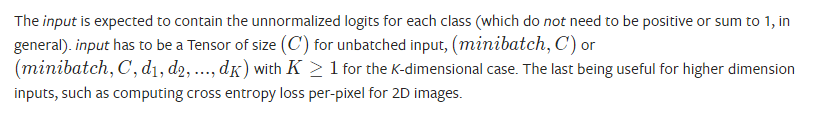

We expect our loss to be less than 4.1743 ie:

```python
import math

result = -math.log(1/65)
print(result)
```

```output
4.174387269895637

```

In [15]:
import math

result = -math.log(1/65)
print(result)


4.174387269895637


In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # tool for converting our x inputs and y targets into vectors

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) # pass inputs and targets
print(f"vocab_size: ",vocab_size)
print(f"logits.shape: ",logits.shape)
print(f"loss: ",loss)

# idx = torch.zeros((1,1), dtype=torch.long)
# print(decode(m.generate(idx=idx, max_new_tokens=100)[0].tolist()))
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


vocab_size:  65
logits.shape:  torch.Size([32, 65])
loss:  tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [ ]:
logits[0]

tensor([-1.5101, -0.0948,  1.0927,  0.1505,  1.6347, -0.0518,  0.4996,  0.7216,
        -0.8968, -0.4122,  1.0030,  0.8508,  0.2178,  0.0328, -0.1699,  1.0659,
        -0.6177,  1.1824,  0.0214, -0.2154, -1.4623,  2.1707,  0.1624,  1.0296,
         0.4154,  0.6207,  0.2341, -0.0326,  1.0124,  1.5122, -0.3359,  0.2456,
         1.8682,  0.7536, -0.1177, -0.1967, -0.9552, -0.8995, -0.9583, -0.5945,
         0.1321, -0.5406,  0.1405, -0.7321,  1.1796,  1.3316, -0.2094,  0.0960,
         0.9040, -0.4032,  0.3027, -0.8034, -1.2537, -1.5195,  0.7446,  1.1914,
        -0.8061, -0.6290,  1.2447, -2.4400,  0.8408, -0.3993, -0.6126, -0.6597,
         0.7624], grad_fn=<SelectBackward0>)

### 00:34:53 Training the Bigram Model


### 00:38:00 Porting Our Code to a Script  Building the "Self-Attention"


### 00:42:13 Version 1: Averaging Past Context with For Loops, the Weakest Form of Aggregation


### 00:47:11 The Trick in Self-Attention: Matrix Multiply as Weighted Aggregation


### 00:51:54 Version 2: Using Matrix Multiply


### 00:54:42 Version 3: Adding Softmax


### 00:58:26 Minor Code Cleanup


### 01:00:18 Positional Encoding


### 01:02:00 The Crux of the Video: Version 4: Self-Attention


### 01:11:38 Note 1: Attention as Communication


### 01:12:46 Note 2: Attention Has No Notion of Space, Operates Over Sets


### 01:13:40 Note 3: There is No Communication Across Batch Dimension


### 01:14:14 Note 4: Encoder Blocks vs. Decoder Blocks


### 01:15:39 Note 5: Attention vs. Self-Attention vs. Cross-Attention


### 01:16:56 Note 6: "Scaled" Self-Attention. Why Divide by sqrt(Head_Size)


### 01:19:11 Building the Transformer: Inserting a Single Self-Attention Block to Our Network


### 01:21:59 Multi-Headed Self-Attention


### 01:24:25 Feedforward Layers of Transformer Block


### 01:26:48 Residual Connections


### 01:32:51 Layernorm (and Its Relationship to Our Previous Batchnorm)


### 01:37:49 Scaling Up the Model! Creating a Few Variables, Adding Dropout


### 01:42:39 Notes on Transformer: Encoder vs. Decoder vs. Both (?) Transformers


### 01:46:22 Super Quick Walkthrough of nanoGPT, Batched Multi-Headed Self-Attention


### 01:48:53 Back to ChatGPT, GPT-3, Pretraining vs. Finetuning, RLHF


### 01:54:32 Conclusions